In [7]:
# CELL 1 — Imports & Globals
import os, random, json, copy
from collections import OrderedDict, defaultdict
import numpy as np
import torch, torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLIENTS = 6
DIRICHLET_ALPHA = 0.3
ROUNDS = 30
LOCAL_EPOCHS = 2
BATCH_SIZE = 16
IMAGE_SIZE = 224
ROOT = "/kaggle/input/brain-tumor-mri-scans"

DELAY_PROB = 0.15
FEDBUFF_APPLY_MULT = 0.6
Q_VAL = 0.2

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

os.makedirs("/kaggle/working/logs", exist_ok=True)
print("Device:", DEVICE)

Device: cuda


In [8]:
# CELL 2 — Dataset & Transforms
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        self.samples = []
        for c in self.classes:
            folder = os.path.join(root_dir, c)
            for f in sorted(os.listdir(folder)):
                if f.lower().endswith(("png","jpg","jpeg","tif","tiff")):
                    self.samples.append((os.path.join(folder, f), self.class_to_idx[c]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, lbl = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, lbl

transform_train = T.Compose([
    T.RandomResizedCrop(IMAGE_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
transform_eval = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

full_dataset = BrainTumorDataset(ROOT, transform=None)
print("Found classes:", full_dataset.classes)
print("Total images:", len(full_dataset))

Found classes: ['glioma', 'healthy', 'meningioma', 'pituitary']
Total images: 7023


In [9]:
# CELL 3 — Train/Val/Test Split
num_total = len(full_dataset)
indices = np.arange(num_total)
np.random.seed(SEED)
np.random.shuffle(indices)

train_frac = 0.80
val_frac = 0.10
n_train = int(train_frac * num_total)
n_val = int(val_frac * num_total)

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]

central_val_loader = DataLoader(Subset(BrainTumorDataset(ROOT, transform=transform_eval), val_idx),
                                batch_size=BATCH_SIZE, shuffle=False)
central_test_loader = DataLoader(Subset(BrainTumorDataset(ROOT, transform=transform_eval), test_idx),
                                 batch_size=BATCH_SIZE, shuffle=False)

print(f"Split sizes -> train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")

Split sizes -> train: 5618, val: 702, test: 703


In [10]:
# CELL 4 — Dirichlet Client Split
def create_dirichlet_split_from_indices(dataset, indices_pool, num_clients, alpha, min_size=30):
    idx_by_class = defaultdict(list)
    for idx in indices_pool:
        _, y = dataset.samples[idx]
        idx_by_class[y].append(idx)

    client_map = {i: [] for i in range(num_clients)}

    for cls, idxs in idx_by_class.items():
        idxs = idxs.copy()
        np.random.shuffle(idxs)
        props = np.random.dirichlet([alpha] * num_clients)
        props = props / props.sum()
        counts = (props * len(idxs)).astype(int)
        counts[-1] = len(idxs) - counts[:-1].sum()
        ptr = 0
        for i in range(num_clients):
            client_map[i].extend(idxs[ptr:ptr+counts[i]])
            ptr += counts[i]

    small = [c for c in client_map if len(client_map[c]) < min_size]
    big = [c for c in client_map if len(client_map[c]) >= min_size]

    leftover = []
    for c in small:
        leftover.extend(client_map[c])
        client_map[c] = []

    if leftover and len(big) > 0:
        np.random.shuffle(leftover)
        share = len(leftover) // len(big)
        for i, c in enumerate(big):
            s = i * share
            e = s + share if i < len(big)-1 else len(leftover)
            client_map[c].extend(leftover[s:e])

    return client_map

client_map = create_dirichlet_split_from_indices(full_dataset, train_idx, NUM_CLIENTS, DIRICHLET_ALPHA, min_size=30)

safe_map = {str(k): [int(x) for x in v] for k, v in client_map.items()}
with open('/kaggle/working/logs/client_map.json', 'w') as f:
    json.dump(safe_map, f)

print("Client map created. Per-client counts:")
for k in client_map:
    print(k, len(client_map[k]))

Client map created. Per-client counts:
0 1104
1 170
2 1060
3 265
4 1733
5 1286


In [11]:
# CELL 5 — Client DataLoaders
client_loaders = {}
for cid, idxs in client_map.items():
    idxs_sh = idxs.copy()
    np.random.seed(SEED + cid)
    np.random.shuffle(idxs_sh)
    n_local_train = int(0.85 * len(idxs_sh))
    tr_idx = idxs_sh[:n_local_train]
    vl_idx = idxs_sh[n_local_train:]
    client_loaders[cid] = {
        "train": DataLoader(Subset(BrainTumorDataset(ROOT, transform=transform_train), tr_idx),
                            batch_size=BATCH_SIZE, shuffle=True,
                            generator=torch.Generator().manual_seed(SEED + cid)),
        "val": DataLoader(Subset(BrainTumorDataset(ROOT, transform=transform_eval), vl_idx),
                          batch_size=BATCH_SIZE, shuffle=False)
    }
print("Built client loaders.")

Built client loaders.


In [12]:
# CELL 6 — Model, Training, Aggregation, Evaluation
class SimpleEffNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_f = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_f, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        n_freeze = int(0.7 * len(list(self.backbone.features.parameters())))
        for i, p in enumerate(self.backbone.features.parameters()):
            if i < n_freeze:
                p.requires_grad = False

    def forward(self, x):
        return self.backbone(x)

def local_train(global_model, loader, epochs, use_fedprox=False, mu=0.08, lr=1e-3):
    if len(loader.dataset) == 0:
        return copy.deepcopy(global_model), 0.0
    model = copy.deepcopy(global_model).to(DEVICE)
    model.train()
    opt = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, epochs))
    loss_fn = nn.CrossEntropyLoss()
    g_params = [p.detach().clone() for p in global_model.parameters()]
    losses = []
    for ep in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            if use_fedprox:
                prox = 0.0
                for lp, gp in zip(model.parameters(), g_params):
                    prox = prox + torch.norm(lp - gp.to(lp.device))**2
                loss = loss + (mu / 2.0) * prox
            loss.backward()
            torch.nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], 1.0)
            opt.step()
            losses.append(float(loss.detach().cpu().numpy()))
        scheduler.step()
    avg_loss = float(np.mean(losses)) if losses else 0.0
    return model, avg_loss

def fedavg_aggregate(global_model, client_models, weights=None):
    g_state = global_model.state_dict()
    new_state = OrderedDict()
    if weights is None:
        weights = [1.0/len(client_models)] * len(client_models)
    for k in g_state:
        if g_state[k].dtype == torch.int64:
            new_state[k] = g_state[k].clone()
            continue
        accum = None
        for i, cm in enumerate(client_models):
            val = cm.state_dict()[k].float().to(g_state[k].device)
            w = weights[i]
            accum = val * w if accum is None else accum + val * w
        new_state[k] = accum.type_as(g_state[k])
    return new_state

class FedBuff:
    def __init__(self):
        self.buffer = []
    def add(self, state, samples, rnd):
        self.buffer.append({"state": {k:v.clone().cpu() for k,v in state.items()}, "samples": samples, "round": rnd})
    def apply(self, current_state, cur_round, apply_prob=0.4, max_age=8, apply_mult=FEDBUFF_APPLY_MULT):
        new_state = OrderedDict((k, v.clone()) for k,v in current_state.items())
        self.buffer = [b for b in self.buffer if (cur_round - b["round"]) <= max_age]
        apply_indices = [i for i in range(len(self.buffer)) if random.random() < apply_prob]
        for idx in sorted(apply_indices, reverse=True):
            b = self.buffer[idx]
            for k in new_state:
                if new_state[k].dtype != torch.int64:
                    delta = b["state"][k].to(new_state[k].device) - new_state[k]
                    new_state[k] = new_state[k] + apply_mult * delta
            del self.buffer[idx]
        return new_state

def compute_q_weights(losses, samples, q=Q_VAL, eps=1e-8):
    w = []
    for i in range(len(samples)):
        L = max(losses[i], eps)
        w.append(samples[i] * ((L + eps) ** q))
    s = sum(w)
    if s <= 0:
        return [s_i / sum(samples) for s_i in samples]
    return [wi / s for wi in w]

def evaluate(model, loader):
    if len(loader.dataset) == 0:
        return 0,0,0,0
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            p = model(xb).argmax(1)
            preds.extend(p.cpu().numpy().tolist())
            labels.extend(yb.cpu().numpy().tolist())
    preds = np.array(preds); labels = np.array(labels)
    acc = 100 * np.mean(preds == labels)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)
    return acc, prec, rec, f1

def print_summary(r, stats):
    print(f"""
================ ROUND {r} ================
Acc        : {stats['acc']:.2f}%
Precision  : {stats['prec']:.3f}
Recall     : {stats['rec']:.3f}
F1 Score   : {stats['f1']:.3f}
Fairness   : {stats['fairness']:.3f}
Avg Stale  : {stats['avg_stale']:.3f}
ClientLoss : {[round(x, 3) for x in stats['losses']]}
Active     : {stats['active']}
Delayed    : {stats['delayed']}
===========================================
""")

NUM_CLASSES = len(full_dataset.classes)
print("Model & functions defined. NUM_CLASSES =", NUM_CLASSES)

Model & functions defined. NUM_CLASSES = 4


In [13]:
# CELL 7 — Attack & Defense Configuration
NUM_MALICIOUS = 2
MALICIOUS_CLIENTS = [0, 1]
NOISE_SCALE = 1.0
FLIP_RATIO = 1.0

print(f"Malicious clients: {MALICIOUS_CLIENTS}")
print(f"Noise scale: {NOISE_SCALE}")
print(f"Flip ratio: {FLIP_RATIO}")

Malicious clients: [0, 1]
Noise scale: 1.0
Flip ratio: 1.0


In [14]:
# CELL 8 — Attack Implementations
class LabelFlipDataset(Dataset):
    """Wraps a dataset and flips labels using a random permutation."""
    def __init__(self, base_dataset, indices, num_classes, flip_ratio=1.0, seed=42):
        self.base_dataset = base_dataset
        self.indices = indices
        self.flip_ratio = flip_ratio
        rng = np.random.RandomState(seed)
        perm = list(range(num_classes))
        while any(perm[i] == i for i in range(num_classes)):
            rng.shuffle(perm)
        self.label_map = perm
        print(f"  [Label Flip] Mapping: {dict(enumerate(self.label_map))}")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, label = self.base_dataset[real_idx]
        if random.random() < self.flip_ratio:
            label = self.label_map[label]
        return img, label

def gaussian_noise_attack(model, noise_scale=5.0):
    """Add Gaussian noise to all trainable parameters (post-training poisoning)."""
    poisoned = copy.deepcopy(model)
    with torch.no_grad():
        for p in poisoned.parameters():
            if p.requires_grad:
                noise = torch.randn_like(p) * noise_scale
                p.add_(noise)
    return poisoned

print("Attack functions defined: LabelFlipDataset, gaussian_noise_attack")

Attack functions defined: LabelFlipDataset, gaussian_noise_attack


In [15]:
# CELL 9 — Defense Implementations (Robust Aggregation)
def krum_aggregate(global_model, client_models, f=None):
    """Krum aggregation — selects the single client model closest to majority."""
    if f is None:
        f = 1  # f=1 tolerates up to 1 Byzantine; needs n > 2*1+2 = 4 active clients
    n = len(client_models)
    if n == 0:
        return global_model.state_dict()
    if n <= 2 * f + 2:
        print(f"  [Krum] Too few clients ({n}) for f={f}, falling back to FedAvg")
        return fedavg_aggregate(global_model, client_models)
    flat_vecs = []
    for cm in client_models:
        vec = torch.cat([p.detach().cpu().float().view(-1) for p in cm.parameters()])
        flat_vecs.append(vec)
    dists = torch.zeros(n, n)
    for i in range(n):
        for j in range(i + 1, n):
            d = torch.norm(flat_vecs[i] - flat_vecs[j]).item()
            dists[i][j] = d
            dists[j][i] = d
    scores = []
    num_closest = n - f - 2
    for i in range(n):
        d_i = dists[i].clone()
        d_i[i] = float('inf')
        closest_dists, _ = torch.topk(d_i, num_closest, largest=False)
        scores.append(closest_dists.sum().item())
    best_idx = int(np.argmin(scores))
    print(f"  [Krum] Selected client index {best_idx} (score={scores[best_idx]:.2f})")
    selected_state = client_models[best_idx].state_dict()
    g_state = global_model.state_dict()
    new_state = OrderedDict()
    for k in g_state:
        new_state[k] = selected_state[k].to(g_state[k].device)
    return new_state

def median_aggregate(global_model, client_models):
    """Coordinate-wise median aggregation."""
    if len(client_models) == 0:
        return global_model.state_dict()
    g_state = global_model.state_dict()
    new_state = OrderedDict()
    for k in g_state:
        if g_state[k].dtype == torch.int64:
            new_state[k] = g_state[k].clone()
            continue
        stacked = torch.stack([cm.state_dict()[k].float().to(g_state[k].device) for cm in client_models], dim=0)
        median_val = torch.median(stacked, dim=0).values
        new_state[k] = median_val.type_as(g_state[k])
    return new_state

print("Defense functions defined: krum_aggregate, median_aggregate")

Defense functions defined: krum_aggregate, median_aggregate


In [16]:
# CELL 10 — Build Poisoned (Label-Flipped) Loaders for Malicious Clients
malicious_loaders = {}
for cid in MALICIOUS_CLIENTS:
    idxs = client_map[cid].copy()
    np.random.seed(SEED + cid)
    np.random.shuffle(idxs)
    n_local_train = int(0.85 * len(idxs))
    tr_idx = idxs[:n_local_train]
    vl_idx = idxs[n_local_train:]
    print(f"Creating label-flipped loader for client {cid} ({len(tr_idx)} train samples)")
    flipped_ds = LabelFlipDataset(
        BrainTumorDataset(ROOT, transform=transform_train),
        tr_idx, NUM_CLASSES, flip_ratio=FLIP_RATIO, seed=SEED + cid
    )
    malicious_loaders[cid] = {
        "train": DataLoader(flipped_ds, batch_size=BATCH_SIZE, shuffle=True,
                            generator=torch.Generator().manual_seed(SEED + cid)),
        "val": DataLoader(Subset(BrainTumorDataset(ROOT, transform=transform_eval), vl_idx),
                          batch_size=BATCH_SIZE, shuffle=False)
    }
print("Poisoned loaders ready.")

Creating label-flipped loader for client 0 (938 train samples)
  [Label Flip] Mapping: {0: 1, 1: 3, 2: 0, 3: 2}
Creating label-flipped loader for client 1 (144 train samples)
  [Label Flip] Mapping: {0: 3, 1: 2, 2: 0, 3: 1}
Poisoned loaders ready.


In [17]:
# CELL 11 — Generic Experiment Runner
def run_experiment(exp_name, attack_type, defense_type):
    """
    attack_type: None, 'label_flip', 'gaussian_noise'
    defense_type: None, 'krum', 'median'
    """
    print(f"Running {exp_name} | DIRICHLET_ALPHA =", DIRICHLET_ALPHA)
    model = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
    buffer = FedBuff()
    log_data = []
    staleness = {cid: 0 for cid in client_map}

    for r in range(ROUNDS):
        active, delayed = [], []
        for cid in client_loaders:
            if random.random() < DELAY_PROB:
                delayed.append(cid); staleness[cid] += 1
            else:
                active.append(cid); staleness[cid] = 0

        client_models, client_losses, client_samples = [], [], []
        for cid in active:
            if attack_type == 'label_flip' and cid in MALICIOUS_CLIENTS:
                loader = malicious_loaders[cid]["train"]
            else:
                loader = client_loaders[cid]["train"]
            lm, loss = local_train(model, loader, LOCAL_EPOCHS, use_fedprox=True, mu=0.08)
            if attack_type == 'gaussian_noise' and cid in MALICIOUS_CLIENTS:
                lm = gaussian_noise_attack(lm, noise_scale=NOISE_SCALE)
            client_models.append(lm); client_losses.append(loss)
            client_samples.append(len(loader.dataset))

        for cid in delayed:
            if attack_type == 'label_flip' and cid in MALICIOUS_CLIENTS:
                loader = malicious_loaders[cid]["train"]
            else:
                loader = client_loaders[cid]["train"]
            lm, loss = local_train(model, loader, LOCAL_EPOCHS, use_fedprox=True, mu=0.08)
            if attack_type == 'gaussian_noise' and cid in MALICIOUS_CLIENTS:
                lm = gaussian_noise_attack(lm, noise_scale=NOISE_SCALE)
            buffer.add(lm.state_dict(), len(loader.dataset), r)

        if len(client_models) > 0:
            if defense_type == 'krum':
                model.load_state_dict(krum_aggregate(model, client_models, f=1))
            elif defense_type == 'median':
                model.load_state_dict(median_aggregate(model, client_models))
            else:
                q_weights = compute_q_weights(client_losses, client_samples, q=Q_VAL)
                model.load_state_dict(fedavg_aggregate(model, client_models, q_weights))

        model.load_state_dict(buffer.apply(model.state_dict(), cur_round=r, apply_prob=0.4, max_age=8, apply_mult=FEDBUFF_APPLY_MULT))

        gacc, prec, rec, f1 = evaluate(model, central_val_loader)
        accs = [evaluate(model, client_loaders[c]["val"])[0] for c in client_loaders]
        fairness = float(np.std(accs)) if len(accs) else 0.0
        avg_stale = float(np.mean(list(staleness.values()))) if len(staleness) > 0 else 0.0

        stats = {"round": r, "acc": gacc, "prec": prec, "rec": rec, "f1": f1,
                 "fairness": fairness, "avg_stale": avg_stale, "losses": client_losses,
                 "active": active, "delayed": delayed}
        print_summary(r, stats); log_data.append(stats)

    with open(f"/kaggle/working/logs/{exp_name}_alpha_{DIRICHLET_ALPHA}.json", "w") as f:
        json.dump(log_data, f, indent=2)
    torch.save(model.state_dict(), f"/kaggle/working/logs/{exp_name}_alpha_{DIRICHLET_ALPHA}_final.pth")
    print(f"{exp_name} finished, model saved.")
    return model, log_data

print("run_experiment() defined.")

run_experiment() defined.


In [18]:
# CELL 12 — Label Flipping Attack, No Defense
_, _ = run_experiment("LabelFlip_NoDefense", attack_type='label_flip', defense_type=None)

Running LabelFlip_NoDefense | DIRICHLET_ALPHA = 0.3
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 135MB/s] 



================ ROUND 0 ================
Acc        : 45.44%
Precision  : 0.539
Recall     : 0.487
F1 Score   : 0.411
Fairness   : 29.089
Avg Stale  : 0.167
ClientLoss : [0.884, 1.144, 1.517, 1.031, 1.016]
Active     : [0, 2, 3, 4, 5]
Delayed    : [1]


================ ROUND 1 ================
Acc        : 25.50%
Precision  : 0.484
Recall     : 0.275
F1 Score   : 0.157
Fairness   : 40.010
Avg Stale  : 0.333
ClientLoss : [0.888, 1.06, 1.32, 0.917, 0.978]
Active     : [0, 2, 3, 4, 5]
Delayed    : [1]


================ ROUND 2 ================
Acc        : 23.79%
Precision  : 0.313
Recall     : 0.255
F1 Score   : 0.126
Fairness   : 41.369
Avg Stale  : 0.000
ClientLoss : [0.882, 0.703, 0.921, 1.141, 0.953, 0.961]
Active     : [0, 1, 2, 3, 4, 5]
Delayed    : []


================ ROUND 3 ================
Acc        : 46.01%
Precision  : 0.523
Recall     : 0.513
F1 Score   : 0.420
Fairness   : 28.850
Avg Stale  : 0.000
ClientLoss : [0.926, 0.699, 1.123, 1.171, 0.968, 0.999]
Active     : 

In [19]:
# CELL 13 — Gaussian Noise Attack, No Defense
_, _ = run_experiment("GaussianNoise_NoDefense", attack_type='gaussian_noise', defense_type=None)

Running GaussianNoise_NoDefense | DIRICHLET_ALPHA = 0.3

================ ROUND 0 ================
Acc        : 19.66%
Precision  : 0.103
Recall     : 0.226
F1 Score   : 0.116
Fairness   : 14.701
Avg Stale  : 0.333
ClientLoss : [0.889, 1.321, 0.993, 1.032]
Active     : [0, 3, 4, 5]
Delayed    : [1, 2]


================ ROUND 1 ================
Acc        : 24.36%
Precision  : 0.061
Recall     : 0.250
F1 Score   : 0.098
Fairness   : 18.747
Avg Stale  : 0.167
ClientLoss : [2.577, 3.468, 4.877, 4.12, 4.449]
Active     : [0, 1, 2, 4, 5]
Delayed    : [3]


================ ROUND 2 ================
Acc        : 24.50%
Precision  : 0.297
Recall     : 0.256
F1 Score   : 0.206
Fairness   : 28.494
Avg Stale  : 0.000
ClientLoss : [1.076, 1.023, 1.422, 1.567, 1.4, 1.388]
Active     : [0, 1, 2, 3, 4, 5]
Delayed    : []


================ ROUND 3 ================
Acc        : 24.64%
Precision  : 0.239
Recall     : 0.255
F1 Score   : 0.222
Fairness   : 10.084
Avg Stale  : 0.167
ClientLoss : [2.261, 

In [20]:
# CELL 14 — Label Flipping + Krum Defense
_, _ = run_experiment("LabelFlip_Krum", attack_type='label_flip', defense_type='krum')

Running LabelFlip_Krum | DIRICHLET_ALPHA = 0.3
  [Krum] Selected client index 4 (score=8.73)

================ ROUND 0 ================
Acc        : 40.60%
Precision  : 0.278
Recall     : 0.459
F1 Score   : 0.316
Fairness   : 31.501
Avg Stale  : 0.167
ClientLoss : [0.848, 1.085, 1.129, 1.688, 0.982]
Active     : [0, 1, 2, 3, 4]
Delayed    : [5]

  [Krum] Selected client index 4 (score=12.45)

================ ROUND 1 ================
Acc        : 66.67%
Precision  : 0.509
Recall     : 0.663
F1 Score   : 0.564
Fairness   : 35.610
Avg Stale  : 0.000
ClientLoss : [0.945, 1.527, 1.157, 1.507, 0.868, 1.173]
Active     : [0, 1, 2, 3, 4, 5]
Delayed    : []

  [Krum] Selected client index 4 (score=8.06)

================ ROUND 2 ================
Acc        : 37.75%
Precision  : 0.432
Recall     : 0.417
F1 Score   : 0.405
Fairness   : 16.766
Avg Stale  : 0.167
ClientLoss : [0.888, 0.984, 1.215, 0.878, 0.932]
Active     : [0, 2, 3, 4, 5]
Delayed    : [1]

  [Krum] Too few clients (3) for f=1, fa

In [21]:
# CELL 15 — Label Flipping + Median Defense
_, _ = run_experiment("LabelFlip_Median", attack_type='label_flip', defense_type='median')

Running LabelFlip_Median | DIRICHLET_ALPHA = 0.3

================ ROUND 0 ================
Acc        : 23.50%
Precision  : 0.059
Recall     : 0.250
F1 Score   : 0.095
Fairness   : 43.615
Avg Stale  : 0.333
ClientLoss : [0.906, 1.175, 1.444, 1.001]
Active     : [0, 2, 3, 4]
Delayed    : [1, 5]


================ ROUND 1 ================
Acc        : 71.94%
Precision  : 0.536
Recall     : 0.699
F1 Score   : 0.606
Fairness   : 41.440
Avg Stale  : 0.167
ClientLoss : [0.932, 0.724, 1.374, 1.037, 0.994]
Active     : [0, 1, 3, 4, 5]
Delayed    : [2]


================ ROUND 2 ================
Acc        : 27.07%
Precision  : 0.326
Recall     : 0.306
F1 Score   : 0.199
Fairness   : 16.183
Avg Stale  : 0.167
ClientLoss : [0.989, 0.932, 1.149, 1.002, 0.87]
Active     : [1, 2, 3, 4, 5]
Delayed    : [0]


================ ROUND 3 ================
Acc        : 56.27%
Precision  : 0.660
Recall     : 0.583
F1 Score   : 0.566
Fairness   : 20.365
Avg Stale  : 0.000
ClientLoss : [0.743, 1.059, 0.977, 

In [22]:
# CELL 16 — Gaussian Noise + Krum Defense
_, _ = run_experiment("GaussianNoise_Krum", attack_type='gaussian_noise', defense_type='krum')

Running GaussianNoise_Krum | DIRICHLET_ALPHA = 0.3
  [Krum] Selected client index 4 (score=9.92)

================ ROUND 0 ================
Acc        : 43.30%
Precision  : 0.256
Recall     : 0.486
F1 Score   : 0.321
Fairness   : 34.044
Avg Stale  : 0.167
ClientLoss : [0.865, 1.052, 1.154, 1.505, 1.026]
Active     : [0, 1, 2, 3, 4]
Delayed    : [5]

  [Krum] Selected client index 3 (score=8.63)

================ ROUND 1 ================
Acc        : 43.73%
Precision  : 0.237
Recall     : 0.490
F1 Score   : 0.312
Fairness   : 34.580
Avg Stale  : 0.167
ClientLoss : [1.745, 1.154, 1.611, 0.836, 1.176]
Active     : [1, 2, 3, 4, 5]
Delayed    : [0]

  [Krum] Too few clients (4) for f=1, falling back to FedAvg

================ ROUND 2 ================
Acc        : 20.09%
Precision  : 0.186
Recall     : 0.194
F1 Score   : 0.165
Fairness   : 4.829
Avg Stale  : 0.333
ClientLoss : [0.974, 2.045, 1.162, 1.754]
Active     : [0, 1, 2, 3]
Delayed    : [4, 5]

  [Krum] Selected client index 4 (score

In [23]:
# CELL 17 — Gaussian Noise + Median Defense
_, _ = run_experiment("GaussianNoise_Median", attack_type='gaussian_noise', defense_type='median')

Running GaussianNoise_Median | DIRICHLET_ALPHA = 0.3

================ ROUND 0 ================
Acc        : 67.81%
Precision  : 0.719
Recall     : 0.703
F1 Score   : 0.675
Fairness   : 17.451
Avg Stale  : 0.000
ClientLoss : [0.894, 1.087, 1.21, 1.322, 1.026, 1.029]
Active     : [0, 1, 2, 3, 4, 5]
Delayed    : []


================ ROUND 1 ================
Acc        : 73.93%
Precision  : 0.781
Recall     : 0.728
F1 Score   : 0.641
Fairness   : 41.734
Avg Stale  : 0.167
ClientLoss : [0.864, 0.939, 1.192, 0.964, 0.949]
Active     : [0, 2, 3, 4, 5]
Delayed    : [1]


================ ROUND 2 ================
Acc        : 32.05%
Precision  : 0.150
Recall     : 0.261
F1 Score   : 0.167
Fairness   : 26.803
Avg Stale  : 0.167
ClientLoss : [0.82, 0.899, 0.86, 1.193, 0.874]
Active     : [0, 1, 2, 3, 4]
Delayed    : [5]


================ ROUND 3 ================
Acc        : 20.23%
Precision  : 0.051
Recall     : 0.250
F1 Score   : 0.084
Fairness   : 16.843
Avg Stale  : 0.167
ClientLoss : [13.

In [24]:
# CELL 18 — Final Comparison: All Scenarios on Test Set
print("=" * 70)
print("FINAL COMPARISON — Attacks & Defenses on Central TEST Set")
print("=" * 70)

scenarios = {
    "Label Flip, No Defense":     f"/kaggle/working/logs/LabelFlip_NoDefense_alpha_{DIRICHLET_ALPHA}_final.pth",
    "Label Flip + Krum":          f"/kaggle/working/logs/LabelFlip_Krum_alpha_{DIRICHLET_ALPHA}_final.pth",
    "Label Flip + Median":        f"/kaggle/working/logs/LabelFlip_Median_alpha_{DIRICHLET_ALPHA}_final.pth",
    "Gaussian Noise, No Defense": f"/kaggle/working/logs/GaussianNoise_NoDefense_alpha_{DIRICHLET_ALPHA}_final.pth",
    "Gaussian Noise + Krum":      f"/kaggle/working/logs/GaussianNoise_Krum_alpha_{DIRICHLET_ALPHA}_final.pth",
    "Gaussian Noise + Median":    f"/kaggle/working/logs/GaussianNoise_Median_alpha_{DIRICHLET_ALPHA}_final.pth",
}

log_files = {k: v.replace("_final.pth", ".json") for k, v in scenarios.items()}

results = []
for name, pth_path in scenarios.items():
    if os.path.exists(pth_path):
        m = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
        m.load_state_dict(torch.load(pth_path, map_location=DEVICE))
        acc, prec, rec, f1 = evaluate(m, central_test_loader)
        avg_loss_last = "N/A"
        log_path = log_files.get(name, "")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                log = json.load(f)
            if log and "losses" in log[-1]:
                avg_loss_last = f"{np.mean(log[-1]['losses']):.4f}"
        results.append((name, acc, prec, rec, f1, avg_loss_last))
    else:
        print(f"  {name}: model NOT FOUND at {pth_path}")

print()
print(f"{'Scenario':<35} {'Acc%':>8} {'Prec':>8} {'Recall':>8} {'F1':>8} {'AvgLoss':>10}")
print("-" * 90)
for name, acc, prec, rec, f1, avg_loss in results:
    print(f"{name:<35} {acc:>7.2f}% {prec:>8.3f} {rec:>8.3f} {f1:>8.3f} {avg_loss:>10}")
print("=" * 90)

print("\nPer-Round Average Loss (Last 5 Rounds):")
print("-" * 90)
print(f"{'Scenario':<35} {'R25':>10} {'R26':>10} {'R27':>10} {'R28':>10} {'R29':>10}")
print("-" * 90)
for name, log_path in log_files.items():
    if os.path.exists(log_path):
        with open(log_path, "r") as f:
            log = json.load(f)
        if len(log) >= 5:
            vals = []
            for entry in log[-5:]:
                if "losses" in entry and entry["losses"]:
                    vals.append(f"{np.mean(entry['losses']):>10.4f}")
                else:
                    vals.append("       N/A")
            print(f"{name:<35} {''.join(vals)}")
print("=" * 90)

import shutil
shutil.make_archive("/kaggle/working/dtfl_attacks_defenses_logs", 'zip', "/kaggle/working/logs")
print("\nAll logs & models zipped to /kaggle/working/dtfl_attacks_defenses_logs.zip")

FINAL COMPARISON — Attacks & Defenses on Central TEST Set

Scenario                                Acc%     Prec   Recall       F1    AvgLoss
------------------------------------------------------------------------------------------
Label Flip, No Defense                83.93%    0.868    0.841    0.841     0.6845
Label Flip + Krum                     86.77%    0.861    0.867    0.859     0.8971
Label Flip + Median                   52.06%    0.557    0.527    0.485     0.6389
Gaussian Noise, No Defense            31.58%    0.307    0.320    0.285    23.4107
Gaussian Noise + Krum                 28.31%    0.259    0.277    0.249    62.4143
Gaussian Noise + Median               36.27%    0.323    0.333    0.284    79.1447

Per-Round Average Loss (Last 5 Rounds):
------------------------------------------------------------------------------------------
Scenario                                   R25        R26        R27        R28        R29
----------------------------------------------

GENERATING PERFORMANCE VISUALIZATIONS


/tmp/ipykernel_55/1821139522.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


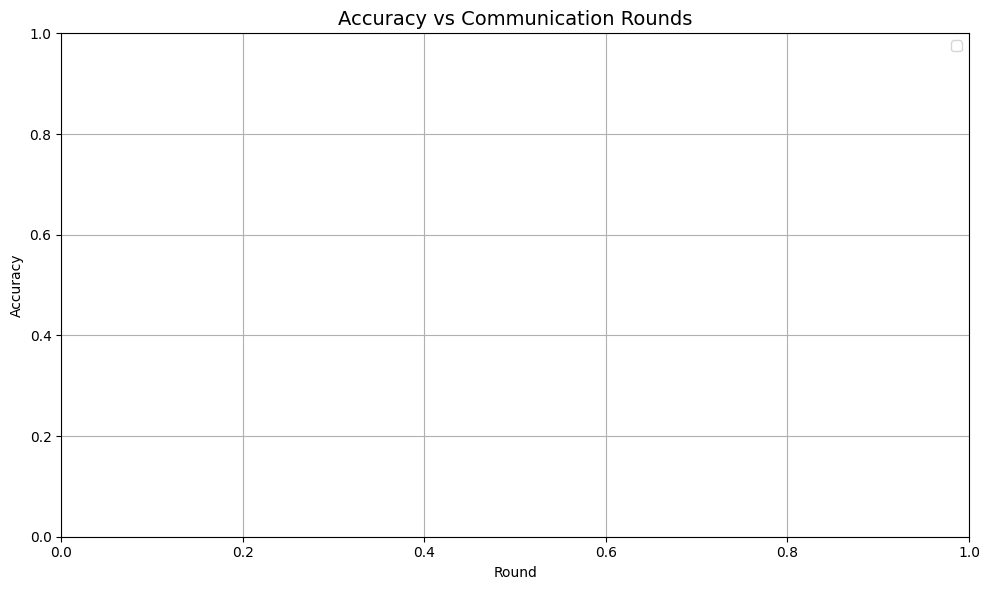

Saved: accuracy_vs_rounds.png


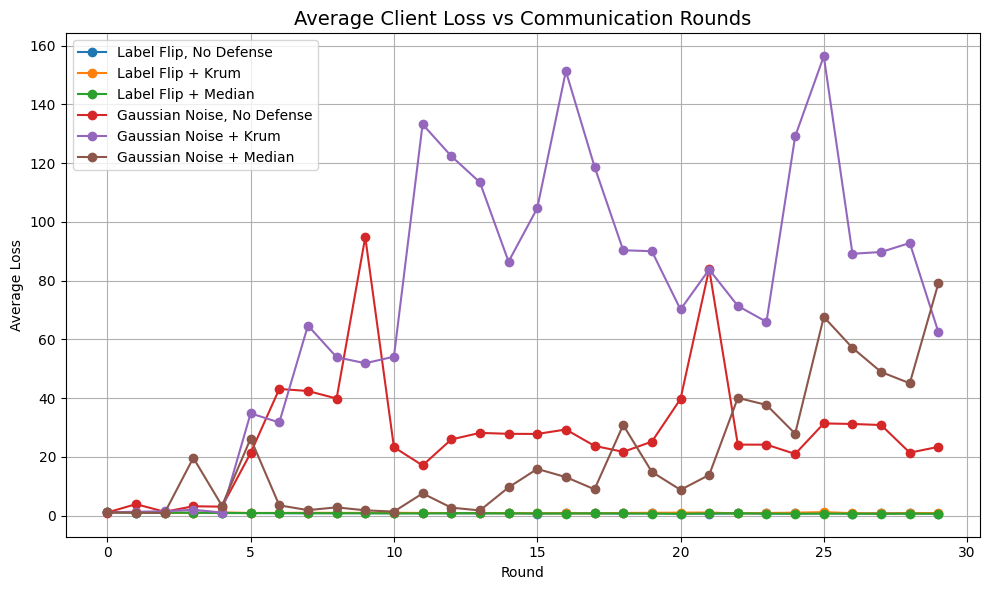

Saved: loss_vs_rounds.png


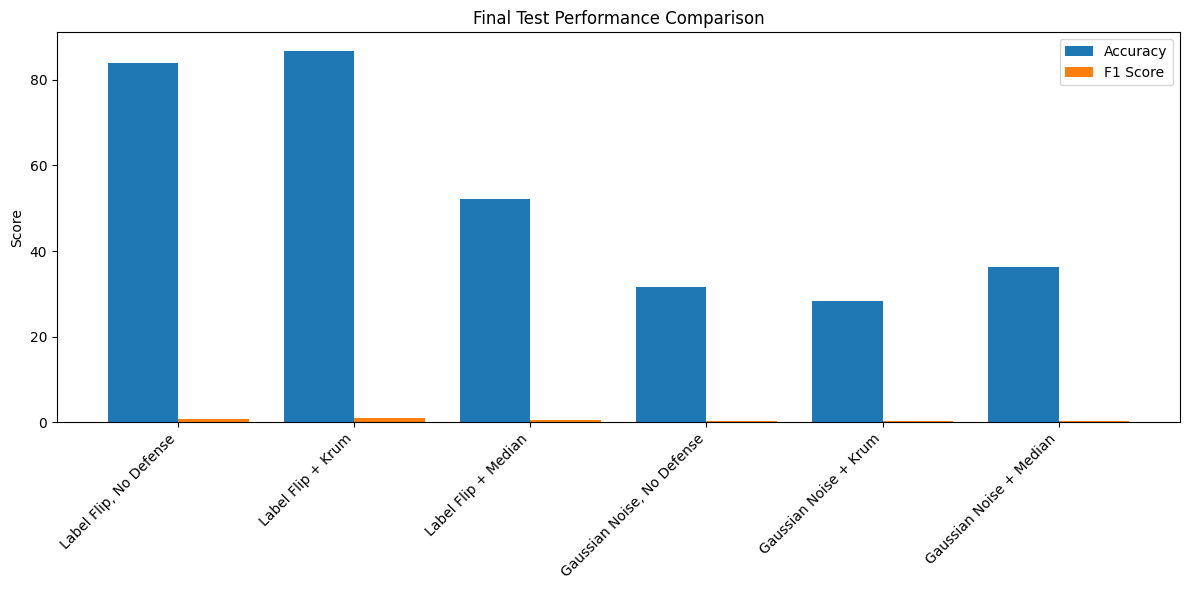

Saved: final_metrics_comparison.png
All graphs generated successfully!


In [25]:
# CELL 19 — Performance Visualization (All Scenarios)
import matplotlib.pyplot as plt

print("=" * 70)
print("GENERATING PERFORMANCE VISUALIZATIONS")
print("=" * 70)

# -----------------------------
# 1️⃣ Load Logs
# -----------------------------
scenario_logs = {}

for name, log_path in log_files.items():
    if os.path.exists(log_path):
        with open(log_path, "r") as f:
            scenario_logs[name] = json.load(f)
    else:
        print(f"Log not found for {name}")

# -----------------------------
# 2️⃣ Accuracy vs Rounds
# -----------------------------
plt.figure(figsize=(10, 6))

for name, log in scenario_logs.items():
    rounds = []
    accs = []
    for entry in log:
        if "round" in entry and "accuracy" in entry:
            rounds.append(entry["round"])
            accs.append(entry["accuracy"])
    if accs:
        plt.plot(rounds, accs, marker='o', label=name)

plt.title("Accuracy vs Communication Rounds", fontsize=14)
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/kaggle/working/accuracy_vs_rounds.png")
plt.show()

print("Saved: accuracy_vs_rounds.png")

# -----------------------------
# 3️⃣ Loss vs Rounds
# -----------------------------
plt.figure(figsize=(10, 6))

for name, log in scenario_logs.items():
    rounds = []
    losses = []
    for entry in log:
        if "round" in entry and "losses" in entry and entry["losses"]:
            rounds.append(entry["round"])
            losses.append(np.mean(entry["losses"]))
    if losses:
        plt.plot(rounds, losses, marker='o', label=name)

plt.title("Average Client Loss vs Communication Rounds", fontsize=14)
plt.xlabel("Round")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/kaggle/working/loss_vs_rounds.png")
plt.show()

print("Saved: loss_vs_rounds.png")

# -----------------------------
# 4️⃣ Final Metrics Comparison
# -----------------------------
if results:
    scenarios_names = [r[0] for r in results]
    accuracies = [r[1] for r in results]
    f1_scores = [r[4] for r in results]

    x = np.arange(len(scenarios_names))

    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, accuracies, width=0.4, label='Accuracy')
    plt.bar(x + 0.2, f1_scores, width=0.4, label='F1 Score')

    plt.xticks(x, scenarios_names, rotation=45, ha='right')
    plt.ylabel("Score")
    plt.title("Final Test Performance Comparison")
    plt.legend()
    plt.tight_layout()
    plt.savefig("/kaggle/working/final_metrics_comparison.png")
    plt.show()

    print("Saved: final_metrics_comparison.png")

print("=" * 70)
print("All graphs generated successfully!")
print("=" * 70)
